# Trying vector codings 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

In [2]:
length_of_protein = 100
num_mutated = 4
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, \
                                mut_probs = [[0.45, 0.45], [0.45], [0.20, 0.20, 0.20], [0.20, 0.20, 0.20]], parent_prob=[0.10, 0.55, 0.40, 0.40])                                    
                                #mut_probs = [[0.45, 0.45], [0.45, 0.45], [0.25, 0.3, 0.35], [0.25, 0.25, 0.4], [0.45, 0.45]], parent_prob=0.1) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 

Parent protein: EVEKWYIFQTMKNHFMCQMGSMVLSRHTKQKVCNHPNTTWQLKYICKQWRGYYISYCGNNLKANGYIRYGKYNYHGSFHYWIQADGGAPVEPSGTNNEVK
Random mutaed positions [ 0  5 50 61]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


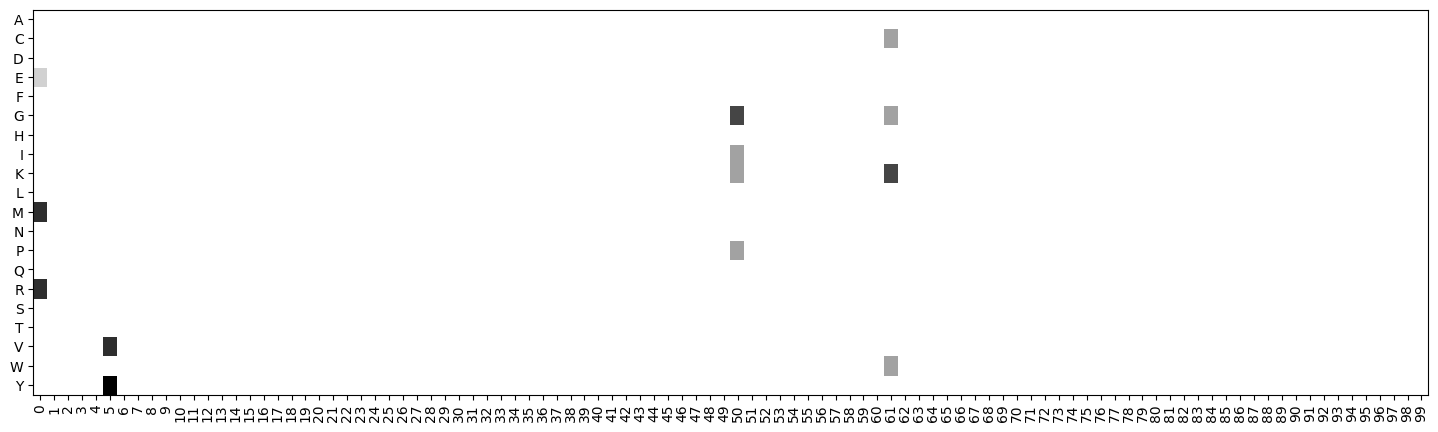

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)
seqs = np.unique(seqs)
print(len(seqs))
probs = S.compute_prob_n_mutations(num_mutated+1)

96


In [5]:
S.mutation_probs_variable_region_indexed

defaultdict(None,
            {0: {'E': 0.1, 'M': 0.45, 'R': 0.45},
             1: {'V': 0.45, 'Y': 0.55},
             2: {'G': 0.4, 'I': 0.2, 'K': 0.2, 'P': 0.2},
             3: {'C': 0.2, 'G': 0.2, 'K': 0.4, 'W': 0.2}})

# Now you have variable length mat to create encoder 

In [6]:
Q = doe_utils.Encoding_basics(S.mutation_probs_variable_region_indexed)



In [7]:
len(Q.feature_names_pairwise)

62

In [8]:
len(Q.pairwise_code_mapper)

6

In [9]:
Q.encode_parent_pairwise

[array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [10]:
Q.code_length_pairwise

np.int64(56)

In [11]:
E = doe_utils.Sequence_encoder_simplex(S.mutation_probs_variable_region_indexed)
independent_codes, pairwise_codes, flatten_independent, flatter_pairwise = E.encode_seqs(seqs)

In [12]:
model = doe_utils.Create_in_silico_model(S.mutation_probs_variable_region_indexed)

(array([ 4.,  9., 16., 17., 19.,  9., 15.,  1.,  2.,  4.]),
 array([-4.66963387, -3.48588996, -2.30214604, -1.11840213,  0.06534178,
         1.24908569,  2.43282961,  3.61657352,  4.80031743,  5.98406135,
         7.16780526]),
 <BarContainer object of 10 artists>)

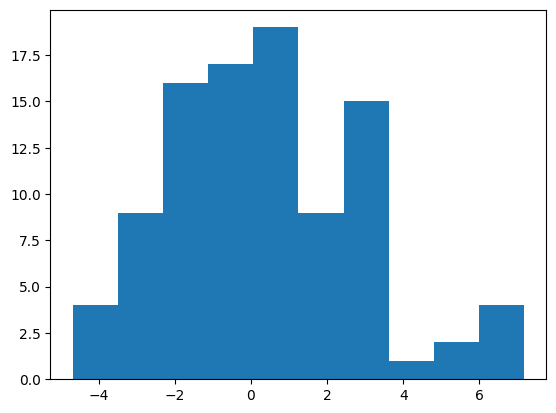

In [13]:
responses = model.model(flatten_independent, flatter_pairwise)
plt.hist(responses)

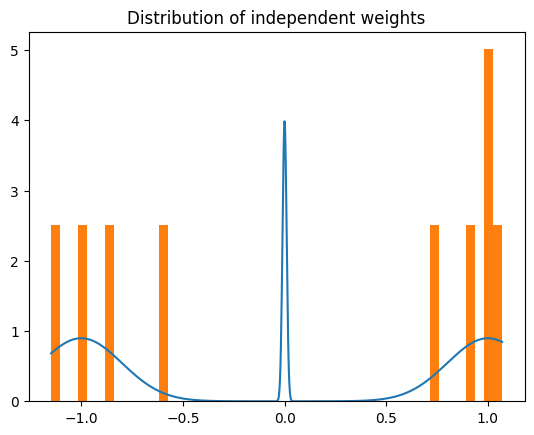

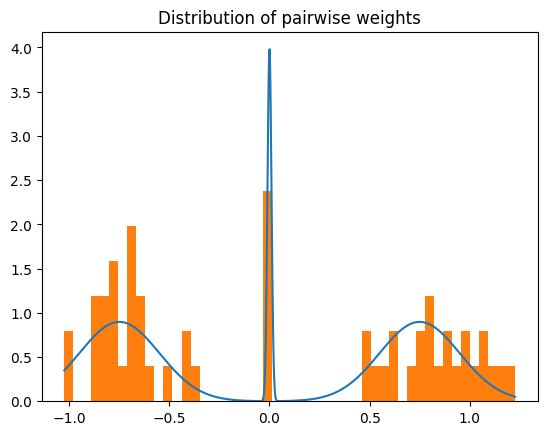

In [14]:
model.plot_weights()

In [15]:
fit_model = doe_utils.Fitting_model(S.mutation_probs_variable_region_indexed)
weights, fit_responses = fit_model.fit(seqs, responses, fit = 'both')

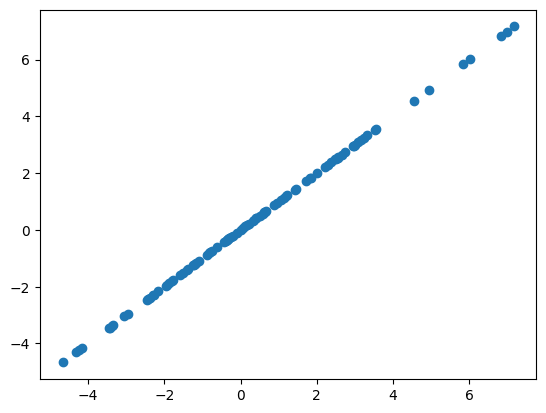

In [16]:
plt.scatter(fit_responses, responses)

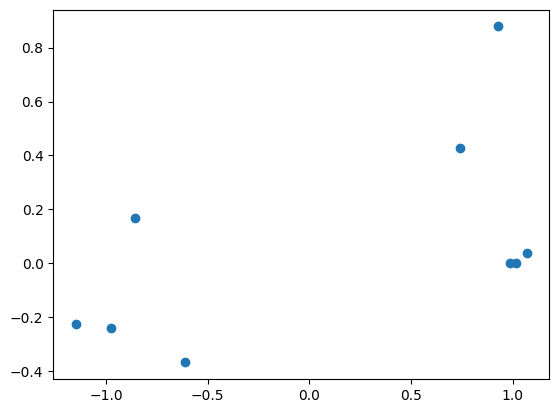

In [17]:
plt.scatter(model.independent_weights, weights[fit_model.independent_indices])

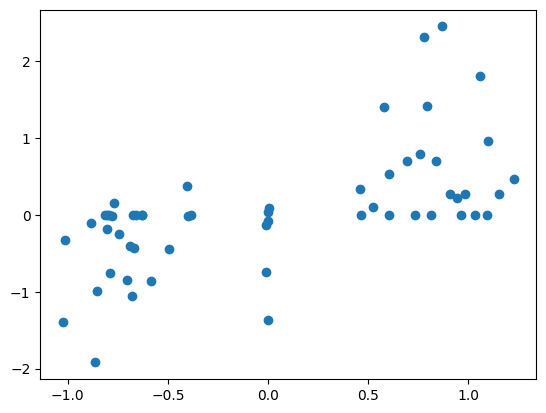

In [18]:
plt.scatter(model.pairwise_weights, weights[fit_model.pairwise_indices])

In [19]:
a, b = np.linalg.eig(fit_model.features.T.dot(fit_model.features))

/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


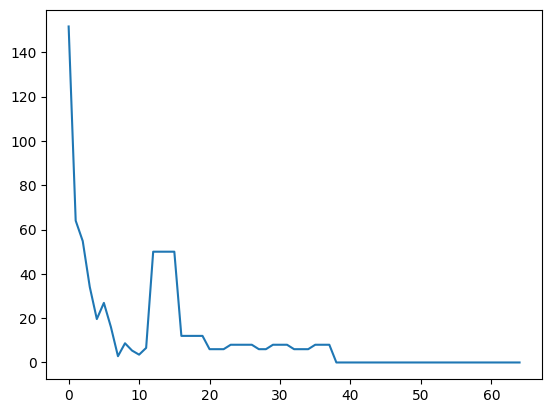

In [20]:
plt.plot(a)

In [30]:
Q.pairwise_constraints

array([[1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

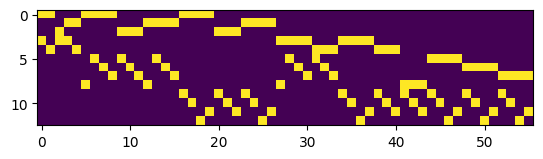

In [31]:
plt.imshow(Q.pairwise_constraints)

In [24]:
# Now create the constraint matrix 
# Need to make sure that J_ia, jb sum over ia or sum over jb are both zero
split_names = np.asarray([re.split(r'[:-]', s) for s in Q.flattened_pair_position_weights_name])
constraints = [] 
for p in Q.feature_names_independent:
    pos, base = p.split('-') 
    inds1 = np.flatnonzero((split_names[:, 0] == pos) & (split_names[:, 2] == base))
    inds2 = np.flatnonzero((split_names[:, 1] == pos) & (split_names[:, 3] == base))  
    v = np.zeros(Q.code_length_pairwise)
    v[np.concatenate([inds1, inds2])] = 1 
    print(p)
    print(Q.flattened_pair_position_weights_name[np.concatenate([inds1, inds2])])
    print('...')
    constraints.append(v)

0-E
['0:1-E:V' '0:1-E:Y' '0:2-E:G' '0:2-E:I' '0:2-E:K' '0:2-E:P' '0:3-E:C'
 '0:3-E:G' '0:3-E:K' '0:3-E:W']
...
0-R
['0:1-R:V' '0:1-R:Y' '0:2-R:G' '0:2-R:I' '0:2-R:K' '0:2-R:P' '0:3-R:C'
 '0:3-R:G' '0:3-R:K' '0:3-R:W']
...
0-M
['0:1-M:V' '0:2-M:I' '0:2-M:K' '0:2-M:P' '0:3-M:C' '0:3-M:G' '0:3-M:W']
...
1-V
['1:2-V:G' '1:2-V:I' '1:2-V:K' '1:2-V:P' '1:3-V:C' '1:3-V:G' '1:3-V:K'
 '1:3-V:W' '0:1-E:V' '0:1-M:V' '0:1-R:V']
...
1-Y
['1:2-Y:I' '1:2-Y:K' '1:2-Y:P' '1:3-Y:C' '1:3-Y:G' '1:3-Y:W' '0:1-E:Y'
 '0:1-R:Y']
...
2-I
['2:3-I:C' '2:3-I:G' '2:3-I:K' '2:3-I:W' '0:2-E:I' '0:2-M:I' '0:2-R:I'
 '1:2-V:I' '1:2-Y:I']
...
2-K
['2:3-K:C' '2:3-K:G' '2:3-K:K' '2:3-K:W' '0:2-E:K' '0:2-M:K' '0:2-R:K'
 '1:2-V:K' '1:2-Y:K']
...
2-P
['2:3-P:C' '2:3-P:G' '2:3-P:K' '2:3-P:W' '0:2-E:P' '0:2-M:P' '0:2-R:P'
 '1:2-V:P' '1:2-Y:P']
...
2-G
['2:3-G:C' '2:3-G:G' '2:3-G:W' '0:2-E:G' '0:2-R:G' '1:2-V:G']
...
3-C
['0:3-E:C' '0:3-M:C' '0:3-R:C' '1:3-V:C' '1:3-Y:C' '2:3-G:C' '2:3-I:C'
 '2:3-K:C' '2:3-P:C']
...
3-G
['0:3-E:

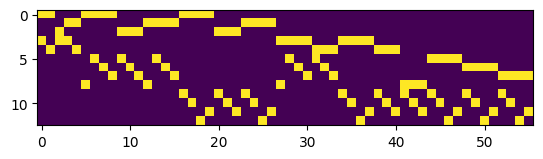

In [25]:
plt.imshow(constraints)

In [26]:
Q.pairwise_code_mapper

{'0:1': {'EV': array([1., 0., 0., 0., 0.]),
  'EY': array([0., 1., 0., 0., 0.]),
  'MV': array([0., 0., 1., 0., 0.]),
  'RV': array([0., 0., 0., 1., 0.]),
  'RY': array([0., 0., 0., 0., 1.]),
  'MY': array([0., 0., 0., 0., 0.])},
 '0:2': {'EG': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'EI': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'EK': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'EP': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  'MI': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  'MK': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  'MP': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  'RG': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  'RI': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  'RK': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  'RP': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  'MG': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 '0:3': {'EC': array([1., 0., 

In [27]:
Q.pairwise_code_mapper
pair_position_weights_name = defaultdict(list) 
for k,v in Q.pairwise_code_mapper.items(): 
    pair_position_weights_name[k] = ['']*Q.pairwise_positional_code_length[k]
    for s,t in v.items(): 
        if np.any(t): 
            pair_position_weights_name[k][np.flatnonzero(t)[0]] = s


In [28]:
pair_position_weights_name

defaultdict(list,
            {'0:1': ['EV', 'EY', 'MV', 'RV', 'RY'],
             '0:2': ['EG',
              'EI',
              'EK',
              'EP',
              'MI',
              'MK',
              'MP',
              'RG',
              'RI',
              'RK',
              'RP'],
             '0:3': ['EC',
              'EG',
              'EK',
              'EW',
              'MC',
              'MG',
              'MW',
              'RC',
              'RG',
              'RK',
              'RW'],
             '1:2': ['VG', 'VI', 'VK', 'VP', 'YI', 'YK', 'YP'],
             '1:3': ['VC', 'VG', 'VK', 'VW', 'YC', 'YG', 'YW'],
             '2:3': ['GC',
              'GG',
              'GW',
              'IC',
              'IG',
              'IK',
              'IW',
              'KC',
              'KG',
              'KK',
              'KW',
              'PC',
              'PG',
              'PK',
              'PW']})

In [29]:
pairwise_position_weights_feature_name = {} 
weight_names = [] 

for k,v in Q.pairwise_code_mapper.items(): 
    for j,l in v.items(): 
        

_IncompleteInputError: incomplete input (3670847485.py, line 6)

In [ ]:
Q.code_length_independent

In [ ]:
Q.code_length_pairwise

# I need more constraints

In [ ]:
Q.pairwise_code_mapper

In [ ]:
fit_model.encoder.number_of_features

In [ ]:
fit_model.encoder.code_length_independent

In [ ]:
fit_model.encoder.code_length_pairwise

In [ ]:
fit_model.encoder.pos_product

In [ ]:
len(fit_model.encoder.feature_names_pairwise)

In [ ]:
115*114

In [ ]:
len(independent_codes)

In [ ]:
flatten_independent = [] 
for ind in independent_codes:
    flatten_independent.append([item for x in ind for item in x])
flatten_independent = np.asarray(flatten_independent) 

flatten_pairwise = [] 
for ind in pairwise_codes:
    flatten_pairwise.append([item for x in ind for item in x])
flatten_pairwise = np.asarray(flatten_pairwise) 

In [ ]:
len(np.unique(flatten_independent, axis = 0))

In [ ]:
len(flatten_independent)

In [ ]:
len(np.unique(flatten_pairwise, axis = 0))

In [ ]:
plt.imshow(flatten_independent, aspect = 'auto', interpolation = 'None')

In [ ]:
a, b=  np.linalg.eig(flatten_independent.T.dot(flatten_independent))
plt.plot(a)

In [ ]:
a, b=  np.linalg.eig(flatten_pairwise.T.dot(flatten_pairwise))
plt.plot(a)

In [ ]:
def _create_zero_mean_pairwise_weights(pairwise_weights, pairwise_feature_names, independent_feature_names): 
    """
    """
    pairwise_vals = np.copy(pairwise_weights) 
    pairwise_vals_old = np.copy(pairwise_vals) 
    # I need to normalize such that \sum_j J_{ij} s_j = 0 so that we don't have an ambiguity in independent weight assignment h_i 
    TOLERANCE = 1e-12
    MAXITER = 100000
    num_iter = 0 
    delta = np.inf
    ## This is make sure \sum_i J_ij and \sum_j J_IJ  is zero
    loc_pair_feature_names = np.asarray([a.split(':') for a in pairwise_feature_names]) 
    loc_pair_feature_names_split = np.asarray([re.split(':' + "|" + '-', a) for a in pairwise_feature_names]) 

    independent_features_split = np.asarray([a.split('-') for a in independent_feature_names]) 
    pos = np.unique(independent_features_split[:,0])
    amino = np.unique(independent_features_split[:,1])

    pos_pairs = np.unique(loc_pair_feature_names_split[:,[0,2]], axis = 0)
    amino_pairs = np.unique(loc_pair_feature_names_split[:,[1,3]], axis = 0)

    
    while (delta > TOLERANCE) and (num_iter < MAXITER): 
        num_iter += 1 
        for i in independent_feature_names: #circle through every independent feature  
            pairwise_vals_old = np.copy(pairwise_vals) 
            inds1 = np.flatnonzero(loc_pair_feature_names[:, 0] == i) 
            inds2 = np.flatnonzero(loc_pair_feature_names[:, 1] == i) 
            inds = np.concatenate((inds1, inds2))
            pairwise_vals[inds] -= np.mean(pairwise_vals[inds]) 
            delta1 = root_mean_squared_error(pairwise_vals, pairwise_vals_old) 

        # need to remove rank 1 components like J_ij =  \sum_ab J_ij, ab
        for p in pos_pairs: 
            inds = np.all(loc_pair_feature_names_split[:, [0,2]] == p, axis = 1)
            pairwise_vals[inds] -= np.mean(pairwise_vals[inds]) 
            delta2 = root_mean_squared_error(pairwise_vals, pairwise_vals_old) 
        # now to reomve rank 1 components like J_ab = \sum_ij J_ij,ab
        # for a in amino_pairs: 
        #     inds = np.all(loc_pair_feature_names_split[:, [1,3]] == a, axis = 1)
        #     pairwise_vals[inds] -= np.mean(pairwise_vals[inds]) 
        #     delta3 = root_mean_squared_error(pairwise_vals, pairwise_vals_old) 
        delta = np.max([delta1, delta2])#, delta3]) 

    
    diff = np.zeros(len(independent_feature_names)) # find the individual weight diff (shift) needed to connrect the pairwise weights 
    for i, k in enumerate(independent_feature_names): #circle through every indepdnent feature  
        inds1 = np.flatnonzero(loc_pair_feature_names[:, 0] == k)
        inds2 = np.flatnonzero(loc_pair_feature_names[:, 1] == k)
        inds = np.concatenate((inds1, inds2)) 
        diff[i] = 0.5*np.mean(pairwise_weights[inds]) #because every term is counted twice, once for s_i and and again for s_j 
    return pairwise_vals, diff 
